# RVC Historic Data Exploratory data Analysis

**Last Modified**: Aug 14, 2025

In this notebook, we calibrate the RVC historic data and apply a prediction model trained on summarized Vectronics data.

In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
import seaborn as sns
import os
import sys
import yaml
from sklearn.preprocessing import LabelEncoder
import torch
from collections import Counter
sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

from scripts.run_RVC_preprocessing import (load_RVC_data,
                                           load_RVC_metadata,
                                           preprocess_RVC_data)

from src.utils.functionalities import (median_pairwise_distance,
                                       mmd_test)
from src.utils.RVC_preprocessing import preprocess_data
import config as config
import src.utils.io as io

In [20]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

## 1. Data Cleaning and Exploratory Data Analysis

In [7]:
df = load_RVC_data()
metadata_df = load_RVC_metadata()

df_summary = df.groupby('animal_id').agg({'UTC date [yyyy-mm-dd]': ['min', 'max', 'count', 'nunique']})
df_summary.columns = ['Start date', 'End date', 'Total no. of windows', 'No. of unique dates']
df_summary


,Start date,End date,Total no. of windows,No. of unique dates
animal_id,,,,
Accra,1970-01-05,2012-08-30,17383,24
Adiga,1970-01-02,2016-03-23,1035272,597
Aztec,1970-01-01,2014-10-01,233280,227
Bali,2015-01-31,2016-03-05,717374,373
Bobedi,1970-01-01,2012-06-22,110643,130
Bongwe,1970-01-03,2016-02-06,487128,276
Brian,1970-01-04,2012-05-31,24424,28
Dar,2012-04-15,2012-05-05,18087,21
Fiji,2016-03-23,2016-11-23,463662,246


In [8]:
# Load RVC config
with open(config.RVC_PREPROCESSING_YAML) as f:
    RVC_preprocessing_config = yaml.safe_load(f)

RVC_feature_cols = RVC_preprocessing_config['feature_cols']
RVC_helper_cols = RVC_preprocessing_config['helper_cols']

In [6]:
# preprocess RVC data
RVC_df = preprocess_data(
        df=df,
        metadata_df=metadata_df,
        feature_cols=RVC_preprocessing_config['feature_cols'],
        helper_cols=RVC_preprocessing_config['helper_cols'],
        summary_dir=io.get_results_dir()
    )

Removed 72191 duplicates.


/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'collar_number'] = 0.0
/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'range'] = 0.0
/home/medhaaga/BotswanaML/notebooks/../src/utils/RVC_calibration.py:272: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-16.28823529 -1

No data found for animal_id Augustus in the date range NaT to NaT
No data found for animal_id Bali in the date range 2013-12-23 00:00:00 to 2014-09-17 00:00:00
No data found for animal_id MJ in the date range NaT to NaT
No data found for animal_id Scorpion in the date range 2012-10-08 00:00:00 to 2012-10-30 00:00:00
No data found for animal_id Scorpion in the date range 2012-11-02 00:00:00 to 2013-10-05 00:00:00
No data found for animal_id Seronera in the date range NaT to NaT
No data found for animal_id Yolo in the date range 2012-09-21 00:00:00 to 2012-10-23 00:00:00
No data found for animal_id Gobi in the date range NaT to NaT
Number of rows without calibration metadata: 53698/7177165
Number of outliers removed: 2623216/7123467.


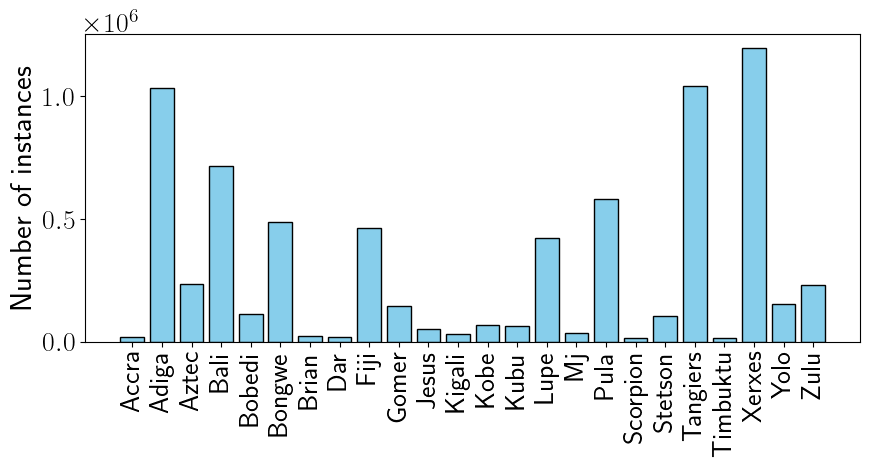

In [9]:
plt.figure(figsize = (10,4))
plt.bar(df_summary.index, df_summary['Total no. of windows'], color='skyblue', edgecolor='black')
plt.ylabel('Number of instances')
plt.xticks(rotation = 90)
plt.show()

Notice the presence of outliers for several dogs, especially Bongwe.

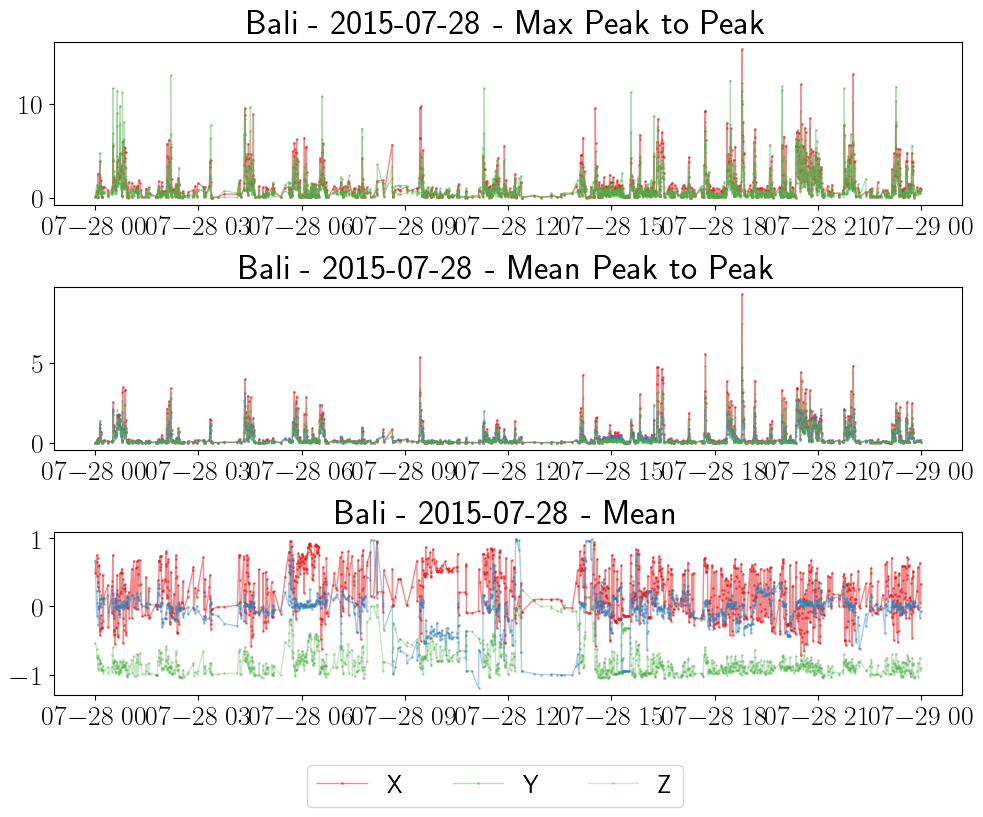

In [9]:
dogs = RVC_df.animal_id.unique()
selected_dog = np.random.choice(dogs)
df_sub = RVC_df[RVC_df.animal_id == selected_dog]
dates = df_sub['UTC date [yyyy-mm-dd]'].unique()
date = np.random.choice(dates)

palette = sns.color_palette("Set1", n_colors=3)

fig, axs = plt.subplots(3, 1, figsize=(10,7.5))

df_tmp = df_sub[df_sub['UTC date [yyyy-mm-dd]'] == date]
loc = AutoDateLocator()
form = AutoDateFormatter(loc)
axs[0].xaxis.set_major_locator(loc)
axs[0].xaxis.set_major_formatter(form)  
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_ptp_max'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='X')
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_ptp_max'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[2], label='Y')
axs[0].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_ptp_max'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Z')
axs[0].set_title(f'{selected_dog} - {str(date)} - Max Peak to Peak')
# axs[0].legend(loc='best')

axs[1].xaxis.set_major_locator(loc)
axs[1].xaxis.set_major_formatter(form)  
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_ptp_mean'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_ptp_mean'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[1].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_ptp_mean'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[1].set_title(f'{selected_dog} - {str(date)} - Mean Peak to Peak')
# axs[1].legend(loc='best')

axs[2].xaxis.set_major_locator(loc)
axs[2].xaxis.set_major_formatter(form)  
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_x_mean'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_y_mean'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[2].plot(df_tmp['UTC time [yyyy-mm-dd HH:MM:SS]'], df_tmp['acc_z_mean'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[2].set_title(f'{selected_dog} - {str(date)} - Mean')
# axs[2].legend(loc='best')

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1))
plt.tight_layout()
plt.show()

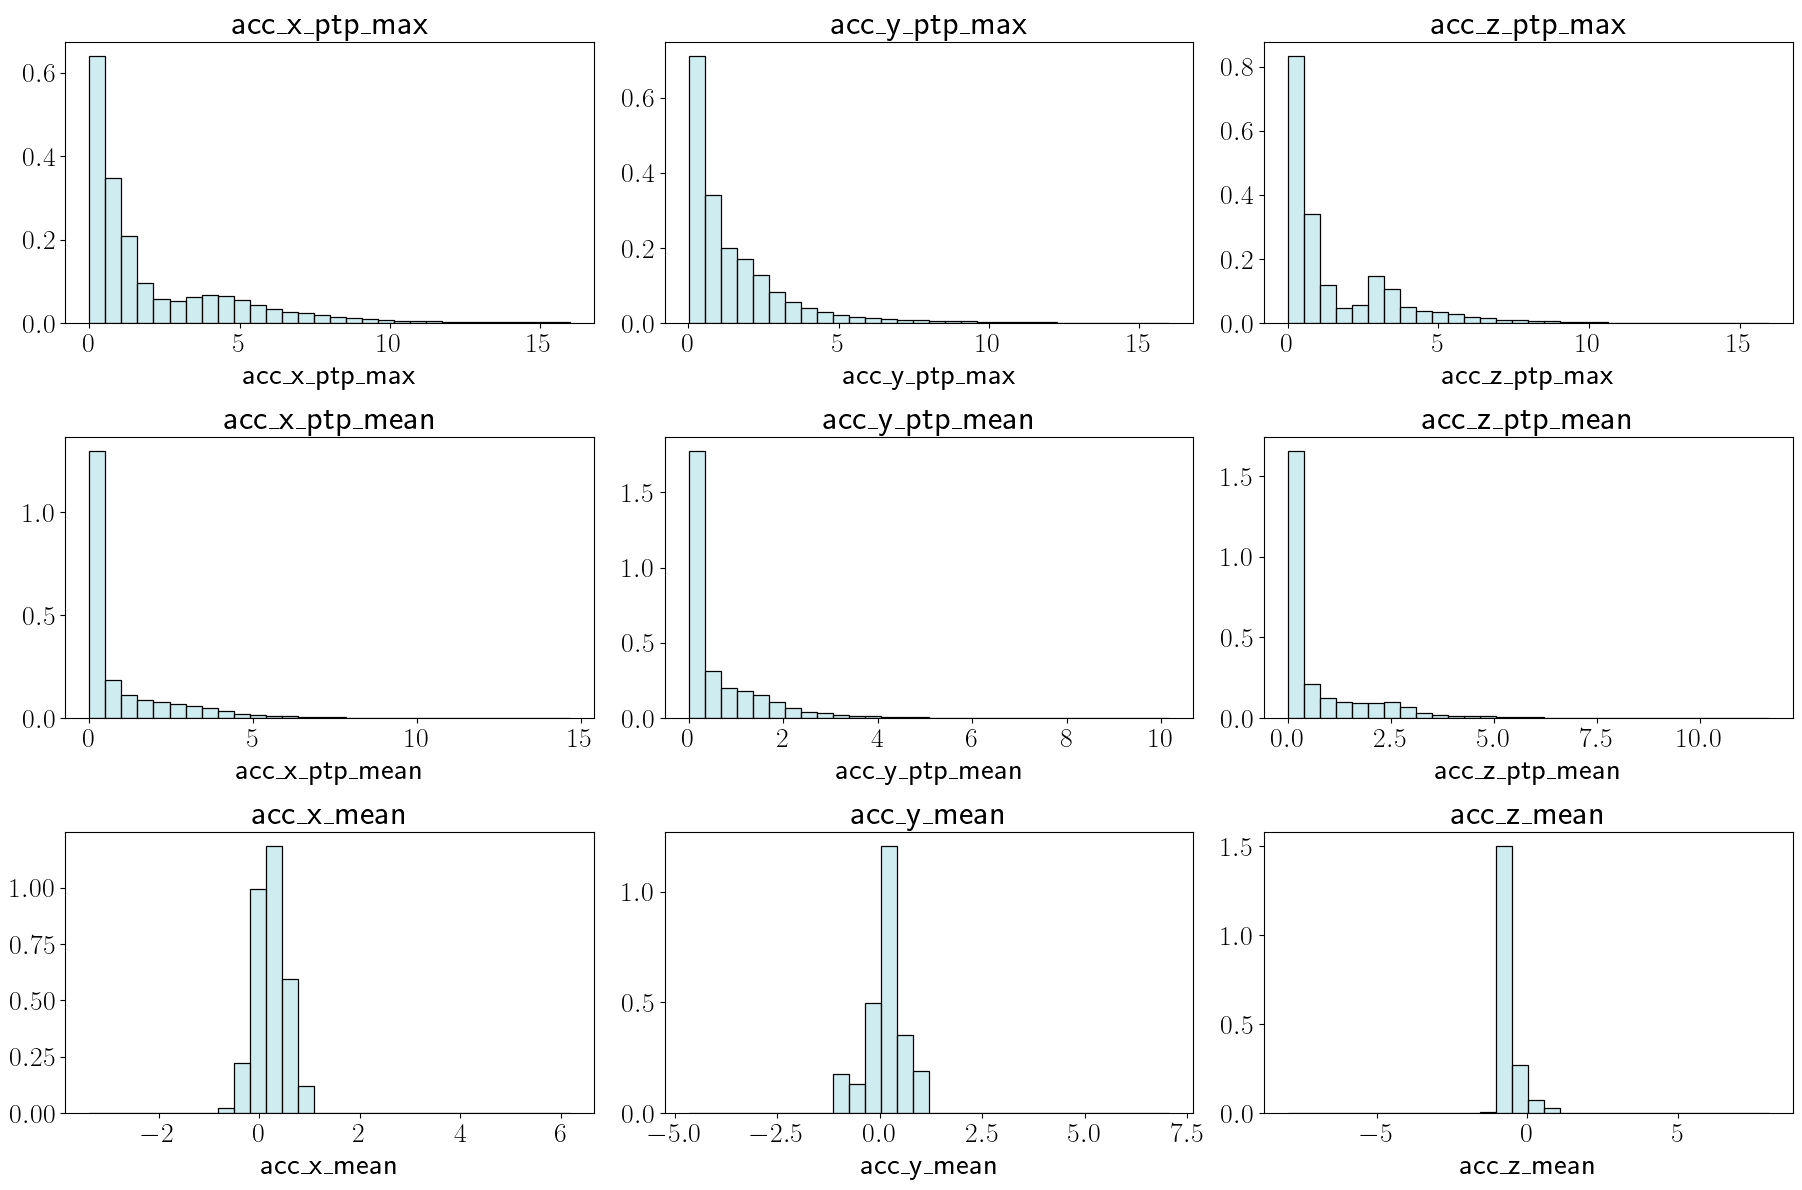

In [10]:
ncols = 3
nrows = int(np.ceil(len(RVC_feature_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
axs = axes.flatten()

for i, col in enumerate(RVC_feature_cols):
        ax = axs[i]
        sns.histplot(
                RVC_df[col],
                kde=False,
                ax=ax,
                stat='density',
                bins=30,
                color='powderblue',
                alpha=0.6
            )

        ax.set_title(col)
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [11]:
# Load Vectronics config
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)

Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']
Vectronics_helper_cols = Vectronics_preprocessing_config['helper_cols']

In [12]:
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path())
vectronics_df = vectronics_df[Vectronics_feature_cols + Vectronics_helper_cols]

/tmp/ipykernel_65990/2136975178.py:37: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


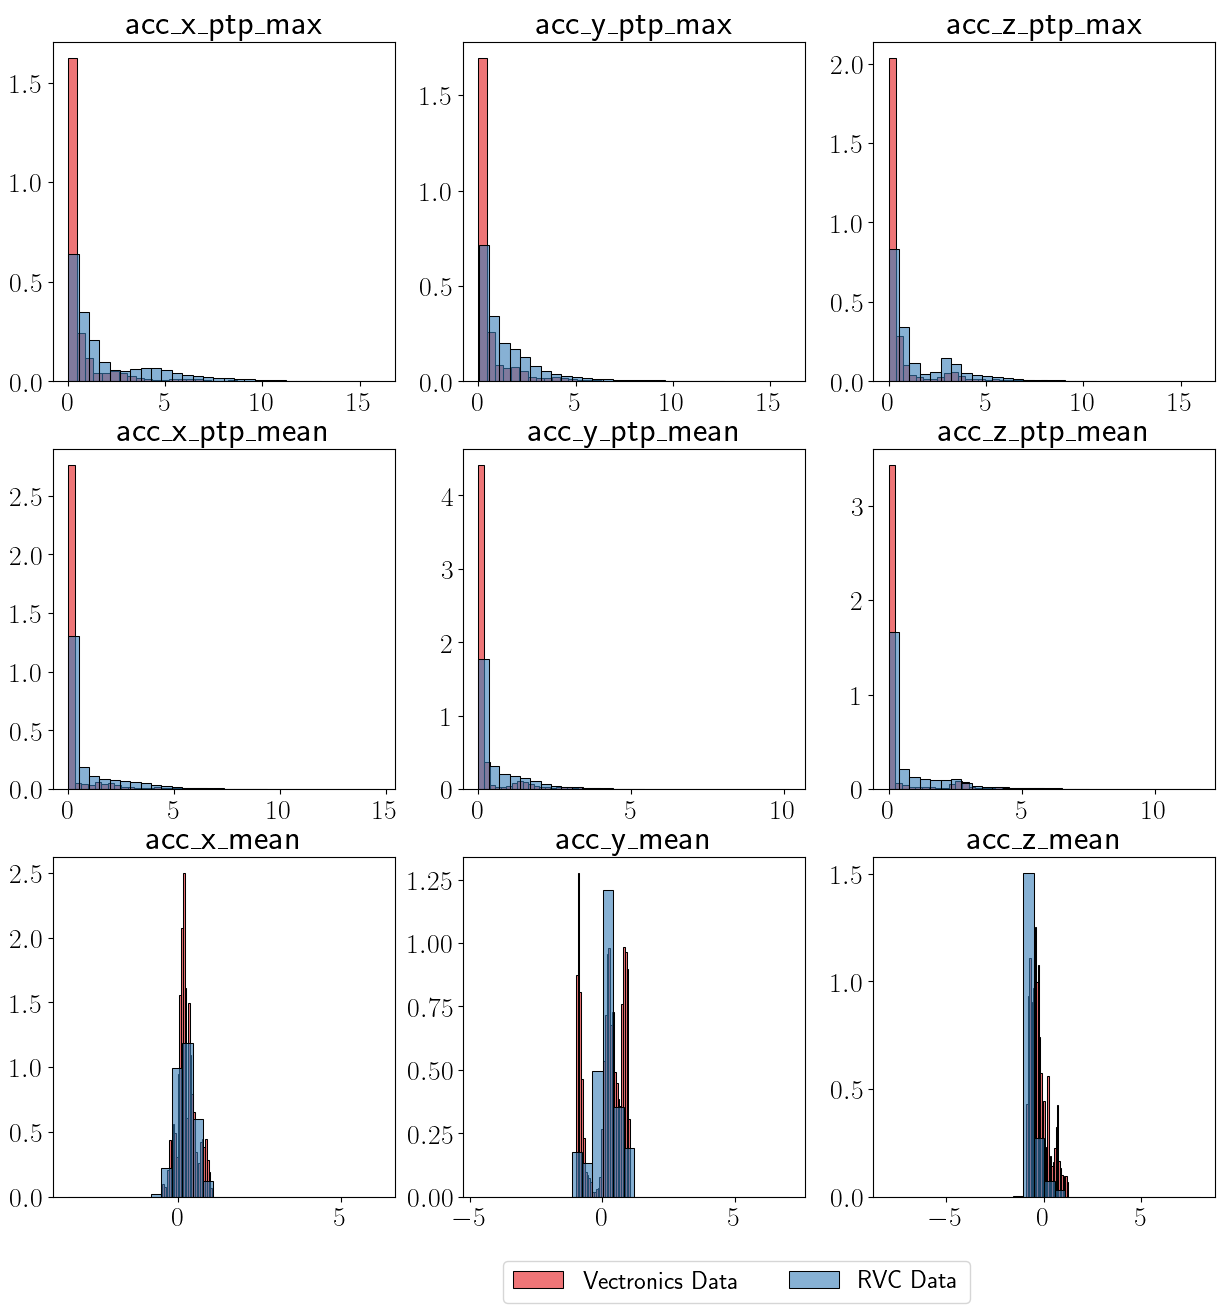

In [13]:
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(15, 5*(len(Vectronics_feature_cols)//3)))
palette = sns.color_palette("Set1", n_colors=2)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                vectronics_df[col],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=0.6
            )

        sns.histplot(
                RVC_df[col],
                kde=False,
                label='RVC Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.6
            )

        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(2.0, -2.75), ncol=2)

plt.tight_layout()
plt.show()


In [14]:
Xs = vectronics_df[Vectronics_feature_cols].values
Xt = RVC_df[Vectronics_feature_cols].values

# shuffle the rows 
np.random.shuffle(Xs)
np.random.shuffle(Xt)

print(f"Number of samples in source data: {Xs.shape[0]}")
print(f"Number of samples in target data: {Xt.shape[0]}")

Number of samples in source data: 7070
Number of samples in target data: 4500251


## 4. Determine Covariate Shift

We compute the sliced Wasserstein distance and Sinkhorn divergence between the two datasets with increasing number of samples $n$ to check if the computed distance decreases as a function of $n$.

In [15]:
n, m = 2000, 2000
sigma = median_pairwise_distance(Xs[:n, :], Xt[:m, :])
stat, permuted_stat, pval = mmd_test(X=Xs[:n, :], Y=Xt[:m, :], sigma=sigma, num_permutations=1000, seed=42)

print(f"MMD^2 statistic: {stat:.4f}")
if pval < 0.05:
    print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H0).")
else:
    print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H0).")

MMD^2 statistic: 0.1085
P-value: 0.0000 - The two distributions are significantly different (reject H0).


## 5. Apply the Prediction Model

In [25]:
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
training_results_dir = os.path.join(io.get_results_dir(), 'summary_training_results')
window_duration, theta, seed = 30.0, 0.7, 1
model_dir = os.path.join(training_results_dir, f"duration{window_duration}_theta{theta}_seed{seed}")
model = torch.load(os.path.join(model_dir, 'model.pt'), weights_only=False).to(device)

In [26]:
label_encoder = LabelEncoder()
label_encoder.fit(config.SUMMARY_BEHAVIORS)

LabelEncoder()

In [31]:
with torch.no_grad():
    y_pred = torch.argmax(model(torch.tensor(Xt, dtype=torch.float32).to(device)), dim=1)
y_pred = label_encoder.inverse_transform(y_pred.cpu().numpy())

In [34]:
counts = Counter(y_pred)
total = len(y_pred)

for cls, count in counts.items():
    print(f"{cls}: {count/total:.2f}")

Feeding: 0.21
Stationary: 0.66
Moving: 0.06
Running: 0.07
